In [1]:
"""
@author Rahul Gupta
"""

import string
import re
import tweepy
import json
import twitterClient

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon

from colorama import Fore, Style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

C:\Users\user\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [4]:
class TwitterProcessing:
    def __init__(self, tokeniser, lStopwords):
        self.tokeniser = tokeniser
        self.lStopwords = lStopwords

    def process(self, text):
        text = text.lower()
        tokens = self.tokeniser.tokenize(text)
        tokensStripped = [tok.strip() for tok in tokens]
        regexDigit = re.compile("^\d+\s|\s\d+\s|\s\d+$")
        regexHttp = re.compile("^http")

        return [tok for tok in tokensStripped if tok not in self.lStopwords and
                regexDigit.match(tok) == None and regexHttp.match(tok) == None]

In [5]:
def computeSentiment(lTokens, setPosWords, setNegWords):
    posNum = len([tok for tok in lTokens if tok in setPosWords])
    negNum = len([tok for tok in lTokens if tok in setNegWords])
    return posNum - negNum

def countWordSentimentAnalysis(setPosWords, setNegWords, tweets, tweetProcessor):
    # Get tweet and remove duplicates
    tweet_text = list(set([tweet['text'] for tweet in tweets]))
    lSentiment = []
    for tweet in tweet_text:
        try:
            tokens = tweetProcessor.process(tweet)
            sentiment = computeSentiment(tokens, setPosWords, setNegWords)
            lSentiment.append([tweet, sentiment])
        except KeyError as e:
            pass
    return lSentiment

def vaderSentimentAnalysis(tweets, tweetProcessor):
    sentAnalyser = SentimentIntensityAnalyzer()
    lSentiment = []
    for tweet in tweets:
        try:
            tweetText = tweet['text']
            tweetDate = tweet['created_at']

            lTokens = tweetProcessor.process(tweetText)
            dSentimentScores = sentAnalyser.polarity_scores(' '.join(lTokens))
            lSentiment.append([pd.to_datetime(tweetDate), tweetText, dSentimentScores['compound']])

        except KeyError as e:
            pass
    return lSentiment

In [6]:
def save_tweets(query, max_tweets, output_file):
    api = twitterClient.twitter_client()
    tweets = []

    for tweet in tweepy.Cursor(api.search, q=query, lang="en").items(max_tweets):
        tweets.append(tweet._json)

    with open(output_file, 'w') as f:
        json.dump(tweets, f)

In [7]:
query = 'streaming service OR streaming movies OR streaming series'
max_tweets = 200
output_file = 'streaming_service.json'

# save_tweets(query, max_tweets, output_file)

Don't read the json file again and again

In [8]:
with open(output_file, 'r') as f:
    for line in f:
        tweets = json.loads(line)

In [9]:
tweetTokenizer = TweetTokenizer()
lPunct = list(string.punctuation)
lStopwords = stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`','’', '‘']

tweetProcessor = TwitterProcessing(tweetTokenizer, lStopwords)

PosWords = opinion_lexicon.positive()
NegWords = opinion_lexicon.negative()

## Sentiment values

In [10]:
lSentiment = countWordSentimentAnalysis(PosWords, NegWords, tweets, tweetProcessor)

In [11]:
streaming_tweets = pd.DataFrame(lSentiment)
streaming_tweets.columns = ['text','Sentiment']

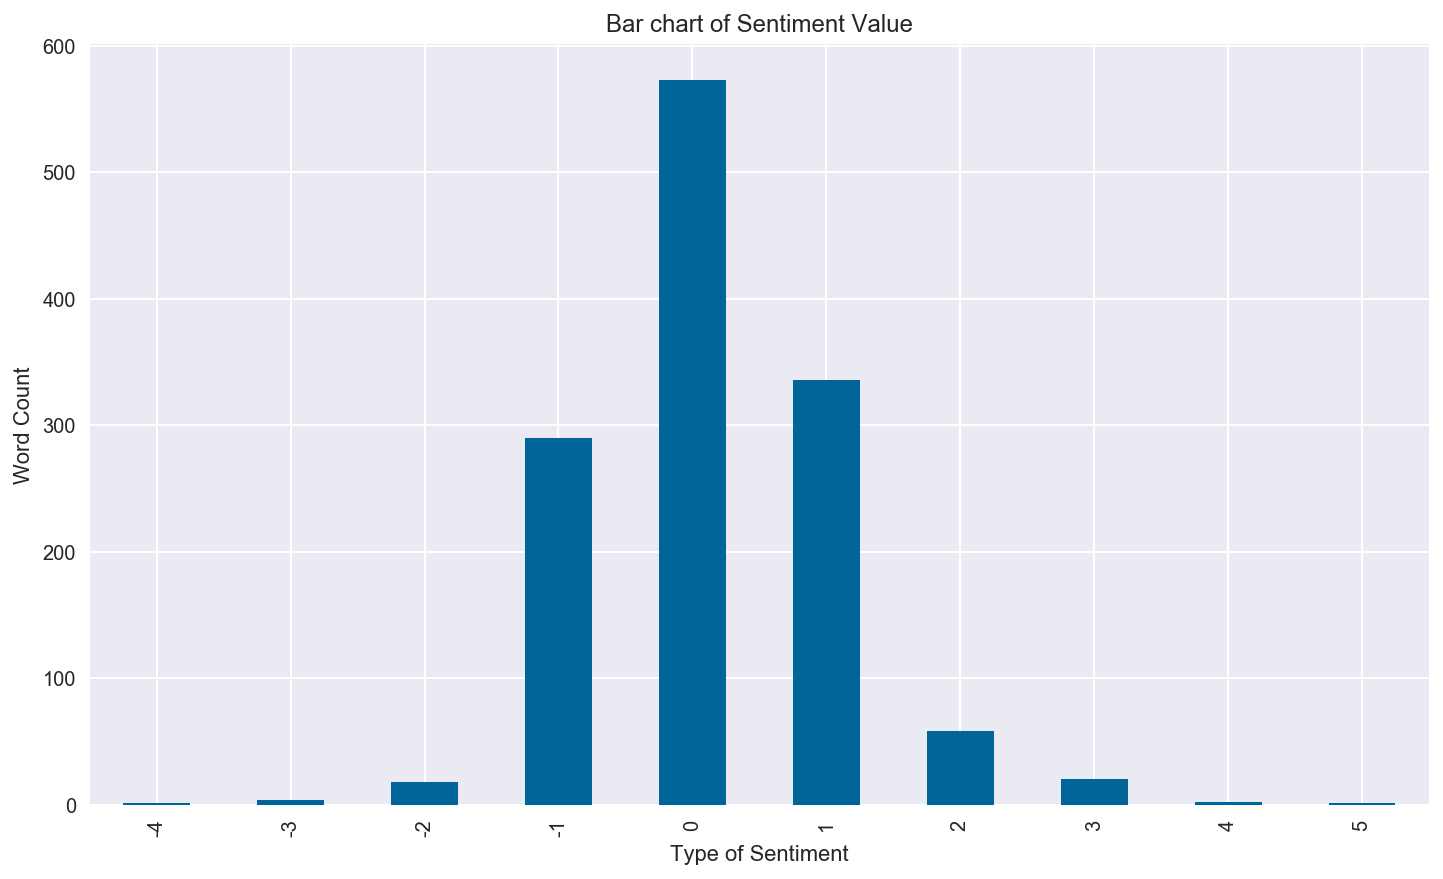

In [12]:
plt.rcParams["figure.figsize"] = (12,7)
pd.value_counts(streaming_tweets['Sentiment'].values, 
                sort=True, ascending=False).sort_index().plot(kind='bar', color='#006699')
plt.ylabel('Word Count')
plt.xlabel('Type of Sentiment')
plt.title('Bar chart of Sentiment Value')
plt.legend().set_visible(False)
plt.show()

* From the chart We can see most of the tweets for Media Streaming are Neutral

* Negative Tweets are Higher than the positive tweets

Next we can analyze some most positive and negative tweets

In [13]:
conditions = [
    (streaming_tweets['Sentiment'] > 0),
    (streaming_tweets['Sentiment'] < 0),
    (streaming_tweets['Sentiment'] == 0),]
choices = ['Positive', 'Negative', 'Neutral']
streaming_tweets['sentiment_type'] = np.select(conditions, choices)

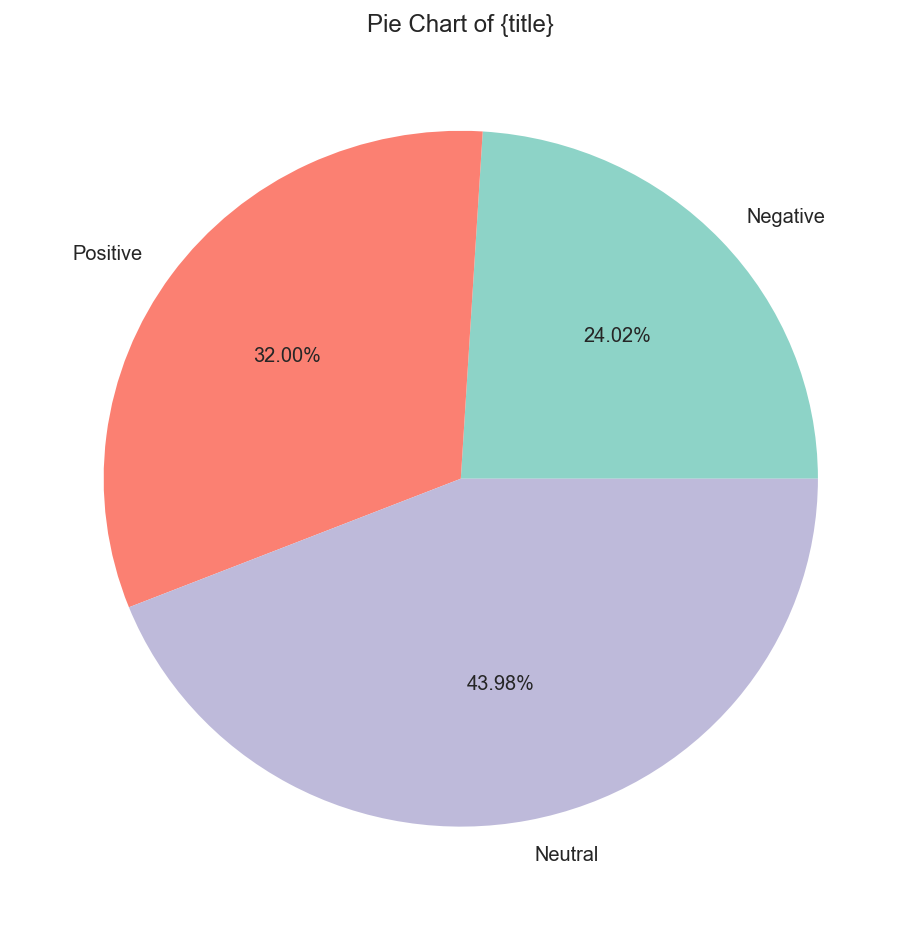

In [14]:
def make_pie_chart(data, column, title = 'Pie chart'):
    plt.rcParams["figure.figsize"] = (8,8)
    color_brewer_set2 = ["#8DD3C7","#FB8072","#BEBADA","#FFFFB3",
                         "#80B1D3","#FDB462","#B3DE69","#FCCDE5", ]

    pd.value_counts(data[column].values, sort=True, ascending=True). \
    plot(kind='pie',autopct='%1.2f%%', colors=color_brewer_set2)
    plt.title('Pie Chart of {title}')
    plt.xlabel('')
    plt.ylabel('')
make_pie_chart(streaming_tweets,'sentiment_type','Sentiments')
plt.show()

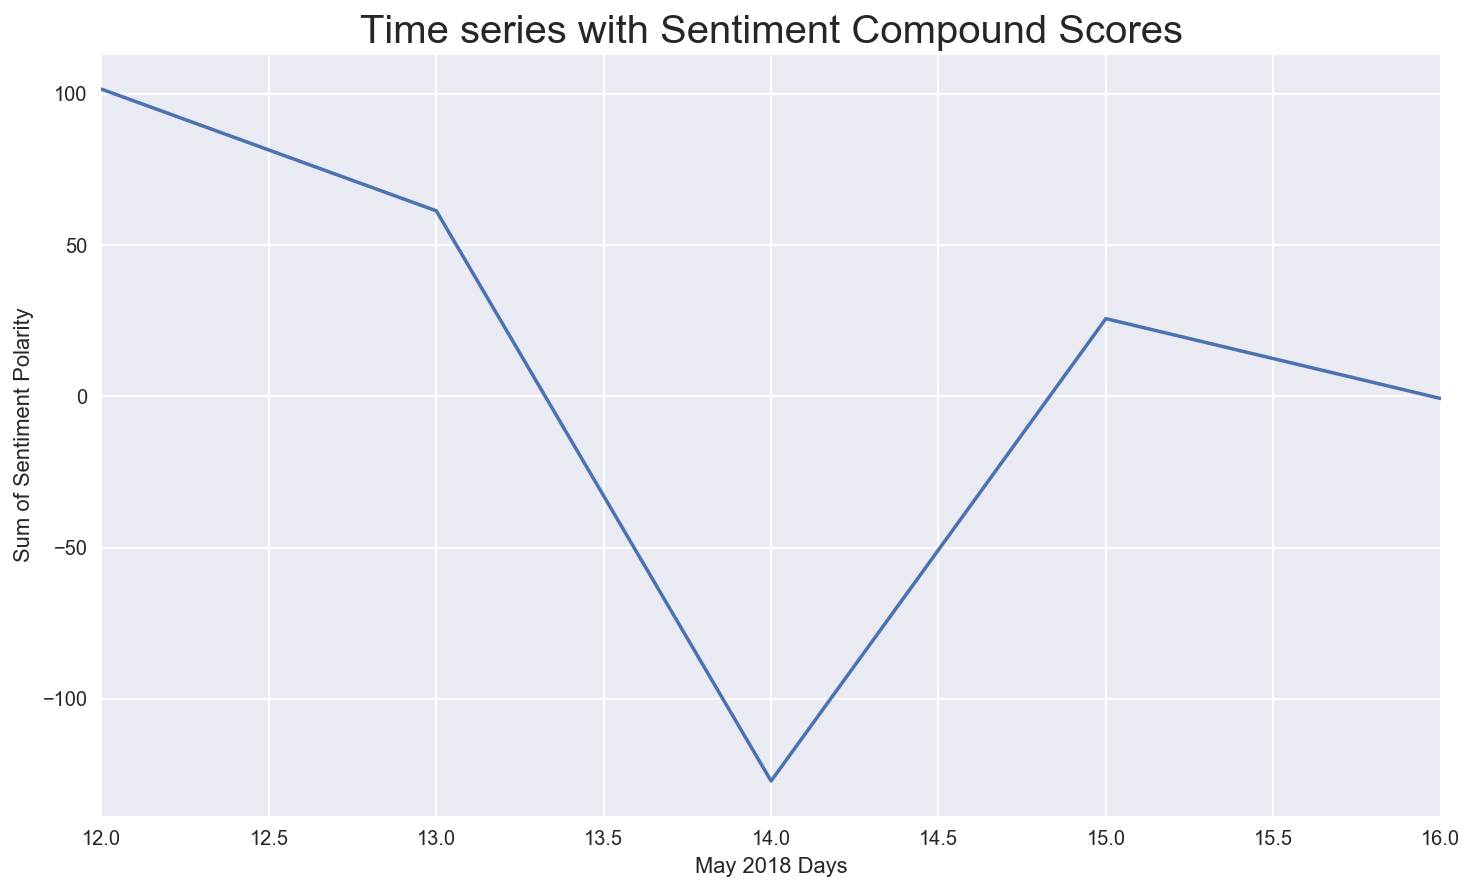

In [15]:
sentiment = vaderSentimentAnalysis(tweets, tweetProcessor)
streaming_compound = pd.DataFrame(sentiment)
streaming_compound.columns = ['Timestamp', 'text','compound']
times = pd.DatetimeIndex(streaming_compound['Timestamp'])
plt.rcParams["figure.figsize"] = (12,7)
streaming_compound.groupby(times.day).compound.sum().plot()
plt.title('Time series with Sentiment Compound Scores', fontsize=20)
plt.xlabel('May 2018 Days')
plt.ylabel('Sum of Sentiment Polarity')
plt.show()

We have many negative tweets on 14-May-2018. This need to be studied as it affected the whole data set polarity

## Key words analysis

**Most Used Keywords**

In [16]:
from collections import Counter
def get_frequent_keywords(tweets, tweetProcessor, limit=15):
    tweet_text = set([tweet['text'] for tweet in tweets])
    freq_counter = Counter()
    for tweet in tweet_text:
        tokens = tweetProcessor.process(tweet)
        freq_counter.update(tokens)
    return freq_counter.most_common(limit)

In [17]:
freq = get_frequent_keywords(tweets, tweetProcessor)
freq_df = pd.DataFrame(freq, columns=['word','count'])
freq_df.sort_values('count', ascending=False, inplace=True)

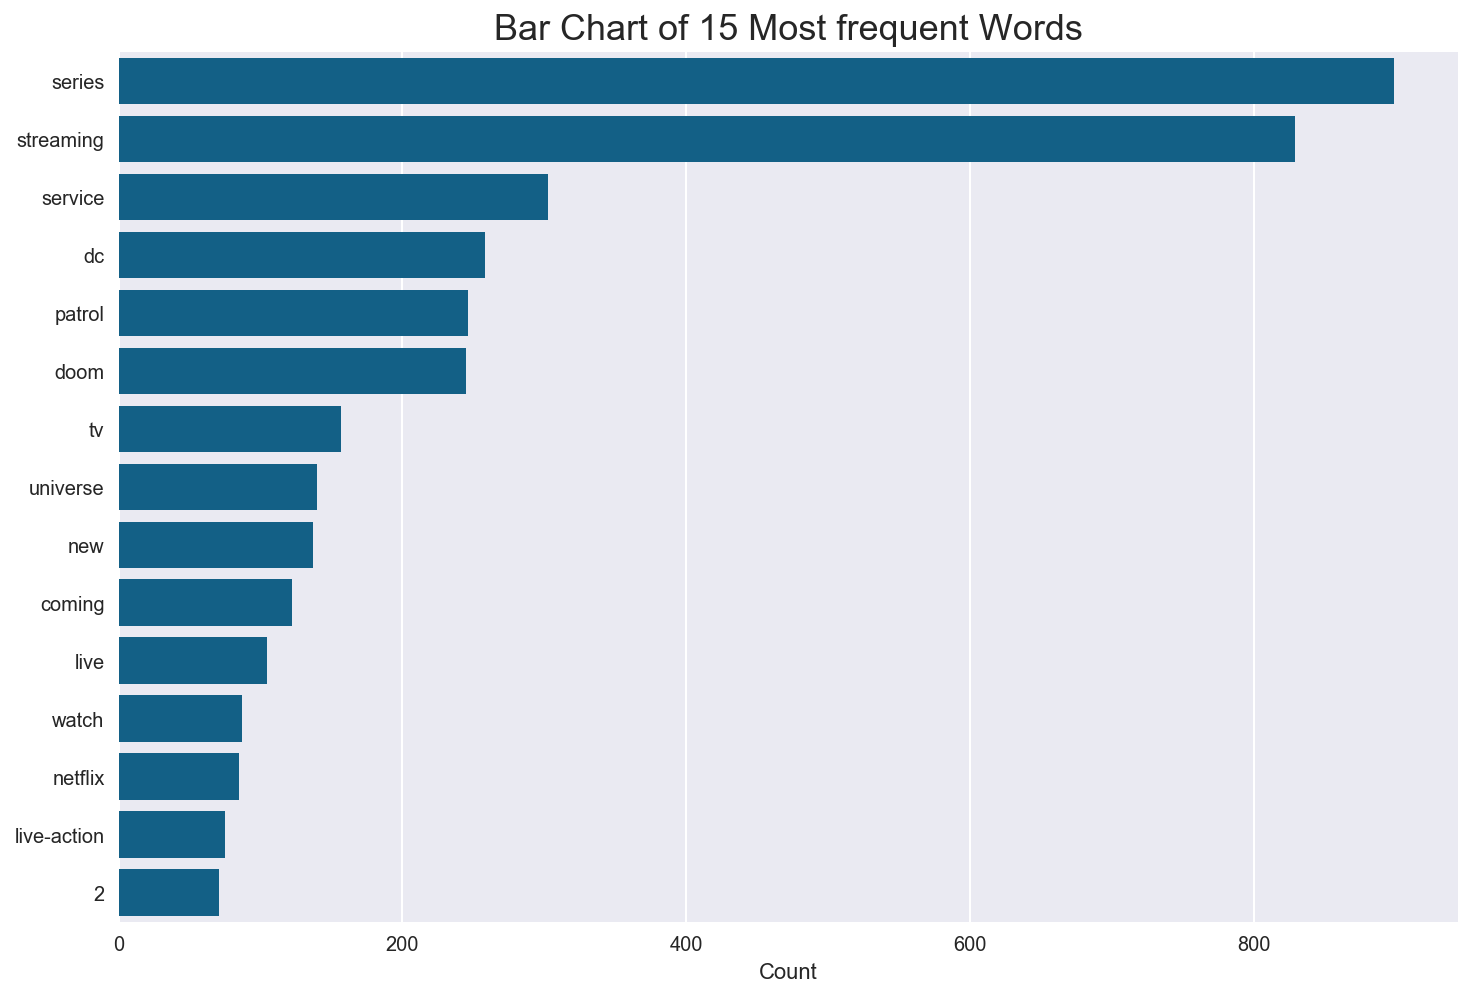

In [18]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
sns.barplot(x='count', y='word', data=freq_df, color='#006699')
plt.title('Bar Chart of 15 Most frequent Words', fontsize=18)
plt.ylabel('')
plt.xlabel('Count')
plt.show()

## Hashtag frequency

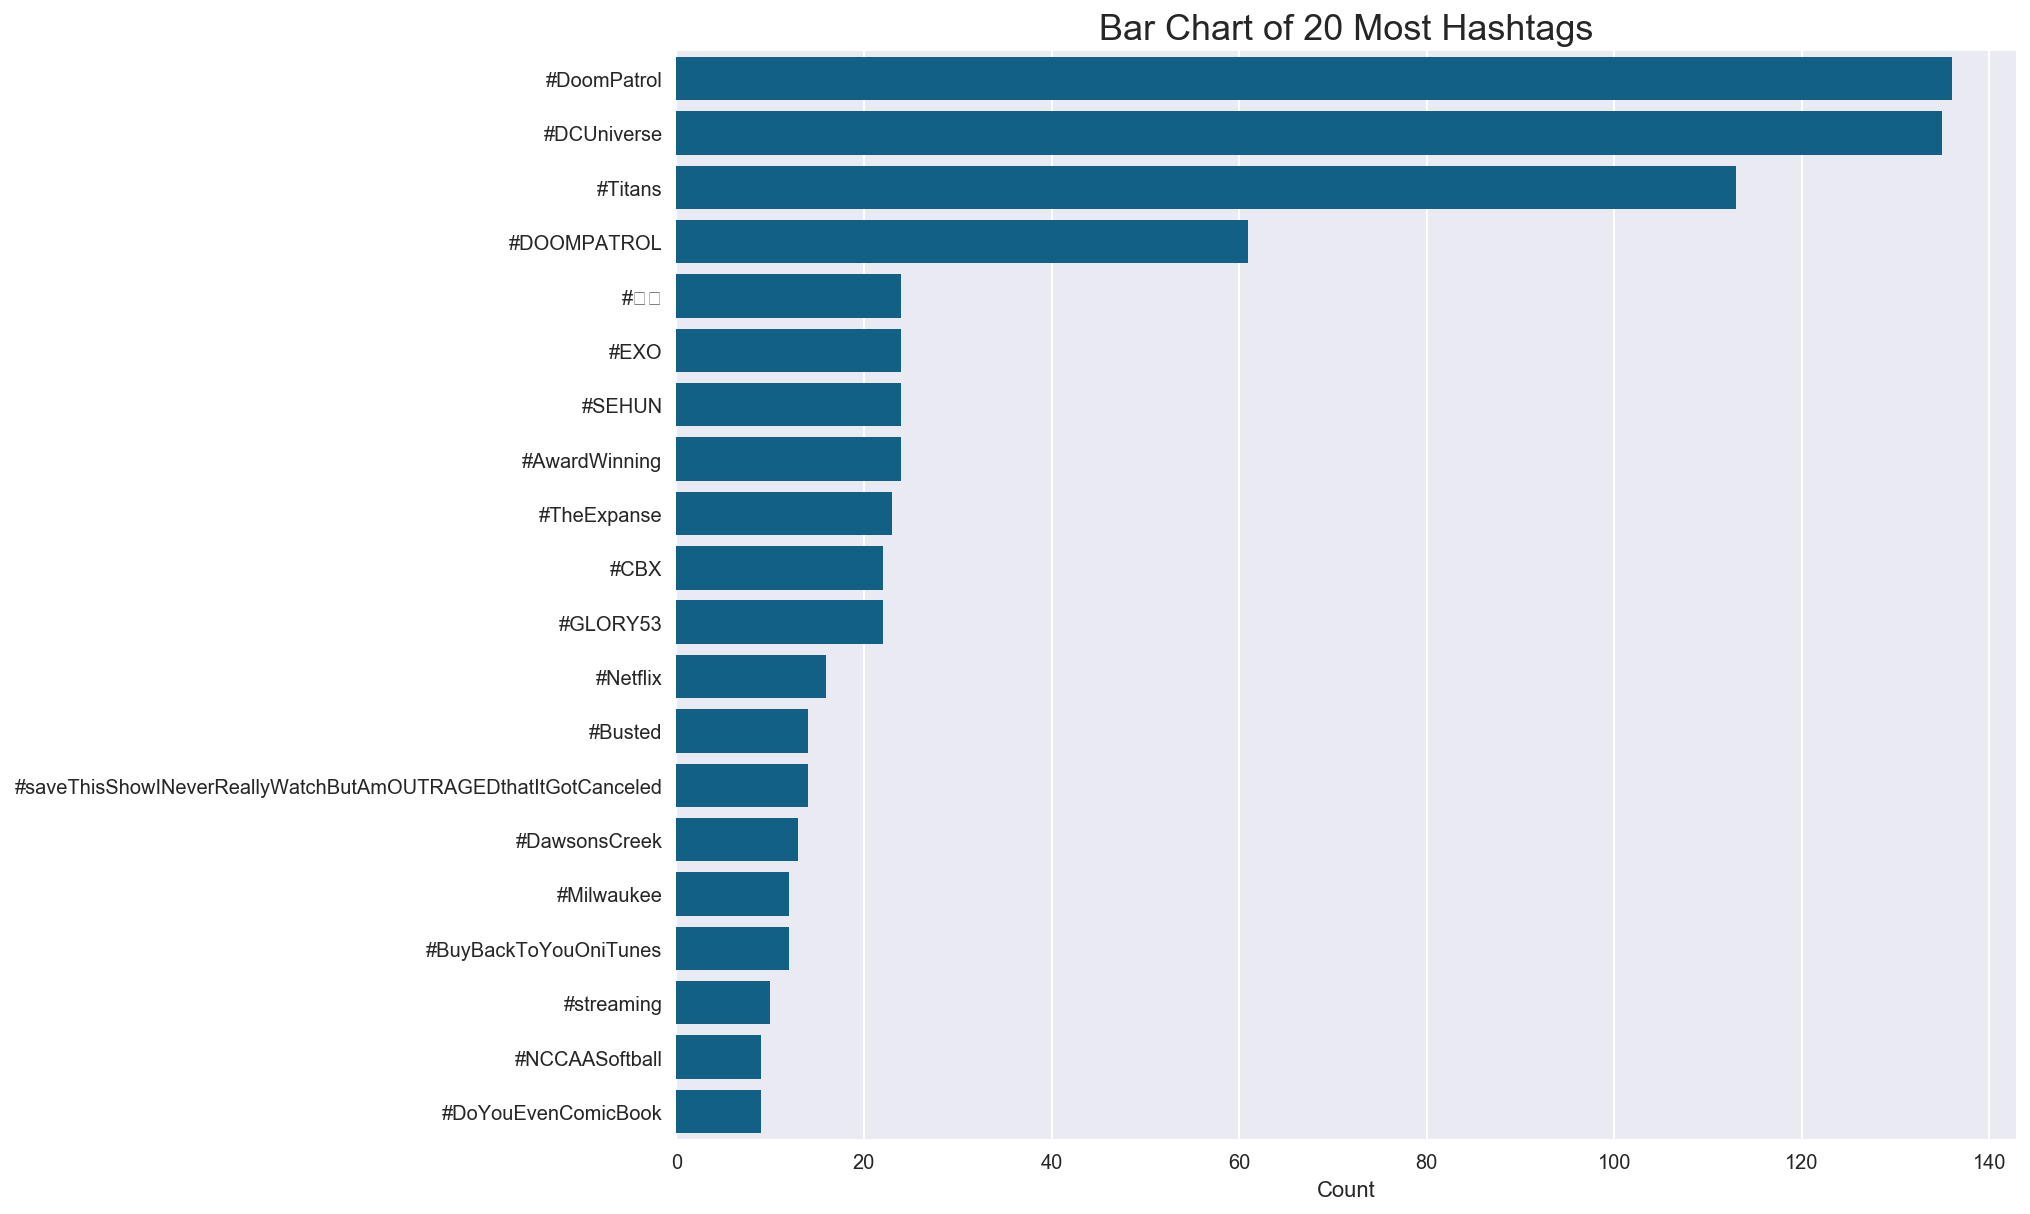

In [19]:
hashtag = []
for tweet in tweets:
    if tweet['entities']['hashtags'] != []:
        for i in tweet['entities']['hashtags']:
            hashtag.append('#' + i['text'])

freq_counter = Counter()
freq_counter.update(hashtag)
freq_df = pd.DataFrame(freq_counter.most_common(20), columns=['word','count'])
freq_df

plt.rcParams['figure.figsize'] = (12, 10)
sns.barplot(x='count', y='word', data=freq_df, color='#006699')
plt.title('Bar Chart of 20 Most Hashtags', fontsize=18)
plt.ylabel('')
plt.xlabel('Count')
plt.show()

### Top Negative Tweets

In [20]:
streaming_tweets.sort_values('Sentiment', inplace=True)
top_negative = list(streaming_tweets.iloc[0:5]['text'])
for text in top_negative:
    print(text)

Any series: you want garbage? You want fucking garbage? You want this bastard we literally pulled out of our garbag… https://t.co/pl0rsz6pFZ
It's funny that complex media (streaming TV series, video games) know exactly which parts killed user interest, but… https://t.co/aod6nvBKlp
Netflix’s Dark is hard to watch, and impossible to stop watching https://t.co/1bzvUDKZPF via @Verge
Fear the Walking Dead is a good show, but they (the characters) made idiot mistakes all the time. I guess it make t… https://t.co/iz6PnzvBcH
Current planned games for streaming:
Far Cry 4 / Far Cry 5
Current planned games for Youtube:
Dark Souls series
Und… https://t.co/PjFjuPcmaY


In [21]:
## Extension 1.1: Reddit Sentiment Analysis

In [22]:
"""
@author Megha Mohan
"""
import praw
import time
import random
import sys
import csv
import math
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from IPython.display import display 
from IPython.display import clear_output
from pprint import pprint
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


C:\Users\user\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


True

In [23]:
reddit = praw.Reddit(client_id='PiURtsGqnsmLEA',
                     client_secret='JodQ8pfG4OJ1TiYQPvkjcCAlG6s',
                     user_agent='SocialMedia')

In [151]:
headlines = set()
for submission in reddit.subreddit('streaming').new(limit=None):
    headlines.add(submission.title)
    print(len(headlines))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
2

In [152]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headlines'] = line
    results.append(pol_score)

pprint(results[:3], width=100)

[{'compound': 0.0, 'headlines': "Pwwweeease Don't Find Me", 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': -0.4588,
  'headlines': 'Streaming Deceit w/ Kittyn_Meow',
  'neg': 0.5,
  'neu': 0.5,
  'pos': 0.0},
 {'compound': 0.0, 'headlines': 'Lenovo Legion series', 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}]


In [153]:
df = pd.DataFrame.from_records(results)
df.head()

,compound,headlines,neg,neu,pos
0,0.0000,Pwwweeease Don't Find Me,0.000,1.000,0.000
1,-0.4588,Streaming Deceit w/ Kittyn_Meow,0.500,0.500,0.000
2,0.0000,Lenovo Legion series,0.000,1.000,0.000
3,0.3089,How do I tell someone I don't want to see them...,0.062,0.812,0.126
4,0.6908,Fortnite S4 Stream - Pay to win 4 sure,0.122,0.348,0.530


In [154]:
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1
df.head()

,compound,headlines,neg,neu,pos,label
0,0.0000,Pwwweeease Don't Find Me,0.000,1.000,0.000,0
1,-0.4588,Streaming Deceit w/ Kittyn_Meow,0.500,0.500,0.000,-1
2,0.0000,Lenovo Legion series,0.000,1.000,0.000,0
3,0.3089,How do I tell someone I don't want to see them...,0.062,0.812,0.126,1
4,0.6908,Fortnite S4 Stream - Pay to win 4 sure,0.122,0.348,0.530,1


In [155]:
df2 = df[['headlines','label']]

In [179]:
df2.to_csv('reddit1_headlines_labels.csv', mode='a', encoding='utf-8', index=False)

In [180]:
df.label.value_counts()

 0    548
 1    353
-1     90
Name: label, dtype: int64

In [181]:
print("Positive headlines:\n")
pprint(list(df[df['label'] == 1].headlines)[:5], width=200)

print("\nNegative headlines:\n")
pprint(list(df[df['label'] == -1].headlines)[:5], width=200)


Positive headlines:

["How do I tell someone I don't want to see them in my streams anymore without being an awful person?",
 'Fortnite S4 Stream - Pay to win 4 sure',
 'Getting that Chicken Dinner with Friends!',
 'Gladiator themed stream going live now! Playing fortnite and having a good time!',
 'About to start a twitch for streaming, looking beginner essentials please read, all advice welcomed!']

Negative headlines:

['Streaming Deceit w/ Kittyn_Meow',
 'PUBG fails with RuthlessDemise',
 'RobBoss24 Playing through Fallout New Vegas : DLC 3 Old World Blues! For a Few Hours, Stop on By!!',
 'Slaying bosses and stealing their gear.',
 'Streaming Batman: The Enemy Within, "Same Stitch" in its entirety at 22:00 EST!']


In [182]:
df.label.value_counts(normalize=True) * 100

 0    55.297679
 1    35.620585
-1     9.081736
Name: label, dtype: float64

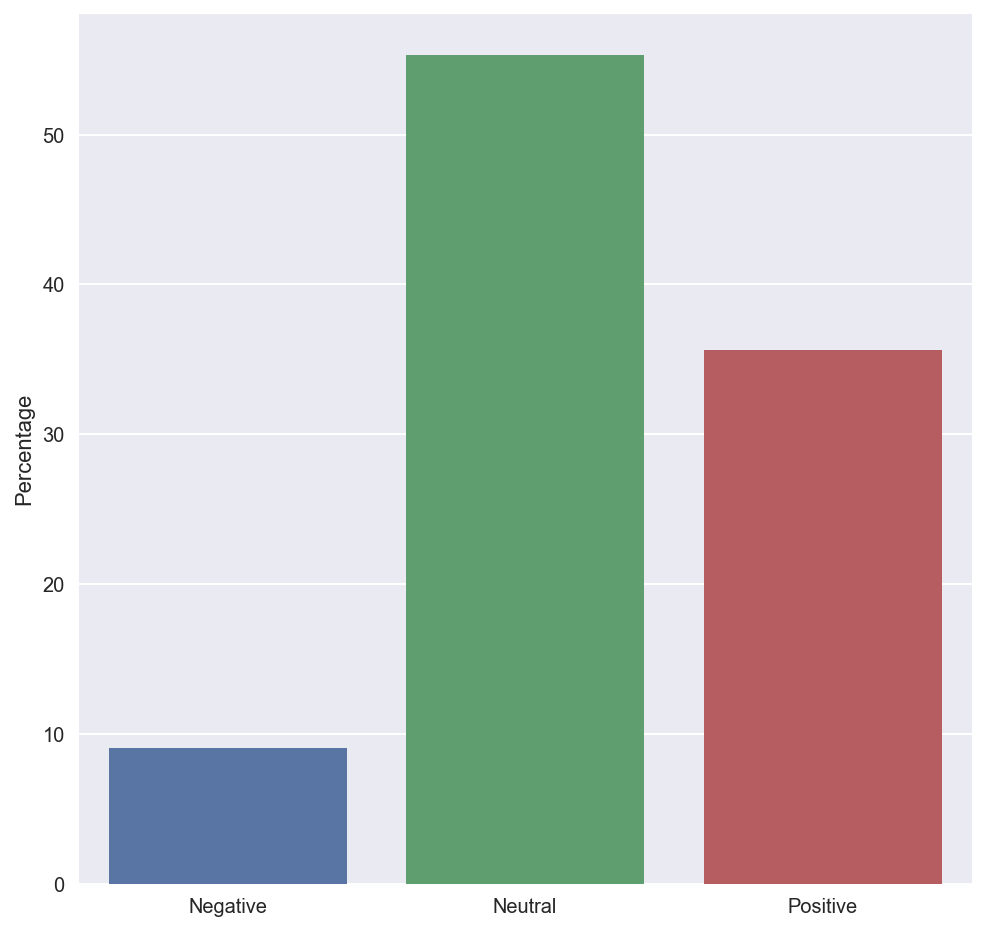

In [183]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [184]:
from nltk.tokenize import word_tokenize, RegexpTokenizer

In [185]:
example = "Thor is the best movie ever"
print(word_tokenize(example, language='english'))

['Thor', 'is', 'the', 'best', 'movie', 'ever']


In [186]:
tokenizer = RegexpTokenizer(r'\w+')
print(tokenizer.tokenize(example))

['Thor', 'is', 'the', 'best', 'movie', 'ever']


In [187]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [188]:
def process_text(headlines):
    tokens = []
    for line in headlines:
        line = line.lower()
        toks = tokenizer.tokenize(line)
        toks = [t for t in toks if t not in stop_words]
        tokens.extend(toks)
    
    return tokens

In [189]:
pos_lines = list(df[df.label == 1].headlines)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

[('streaming', 81),
 ('stream', 69),
 ('help', 64),
 ('come', 57),
 ('playing', 45),
 ('fortnite', 38),
 ('new', 38),
 ('join', 29),
 ('play', 28),
 ('live', 26),
 ('twitch', 26),
 ('streamer', 25),
 ('need', 23),
 ('hours', 20),
 ('2', 20),
 ('friends', 17),
 ('please', 17),
 ('check', 17),
 ('game', 17),
 ('games', 16)]

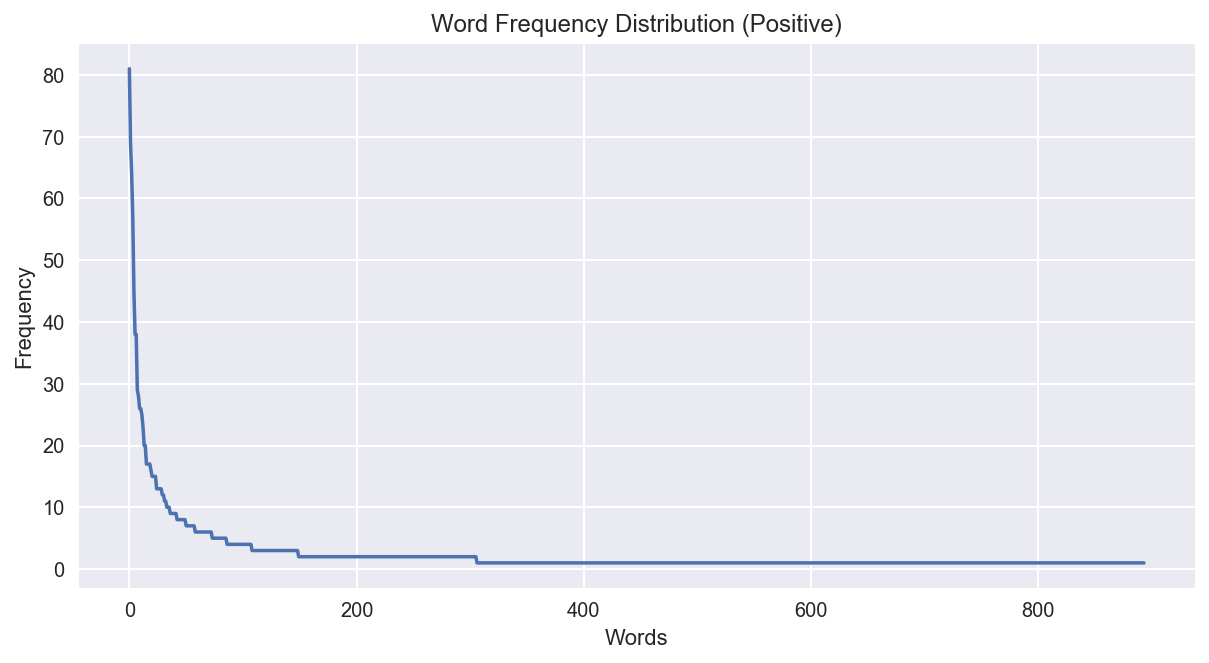

In [190]:

y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

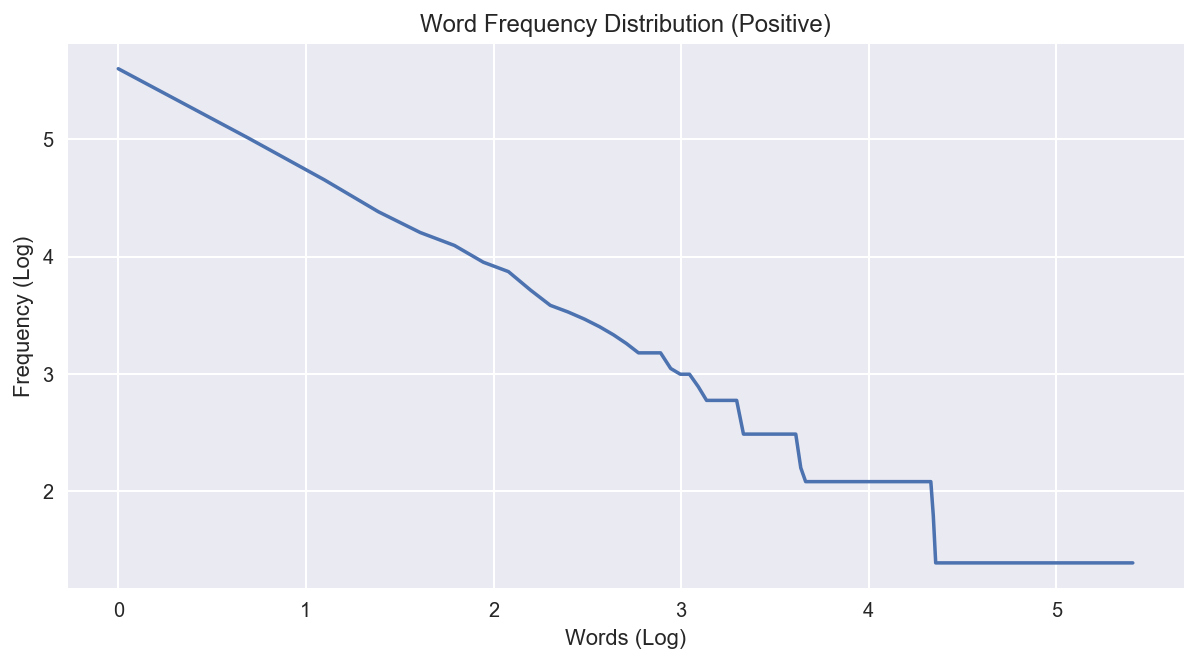

In [191]:
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
plt.show()

In [192]:
neg_lines = list(df2[df2.label == -1].headlines)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20)

[('streaming', 26),
 ('stream', 14),
 ('live', 11),
 ('dead', 10),
 ('come', 10),
 ('est', 9),
 ('new', 8),
 ('hours', 8),
 ('twitch', 8),
 ('2', 8),
 ('tv', 6),
 ('fortnite', 6),
 ('playing', 5),
 ('3', 5),
 ('5', 5),
 ('first', 5),
 ('next', 5),
 ('hi', 5),
 ('stop', 4),
 ('batman', 4)]

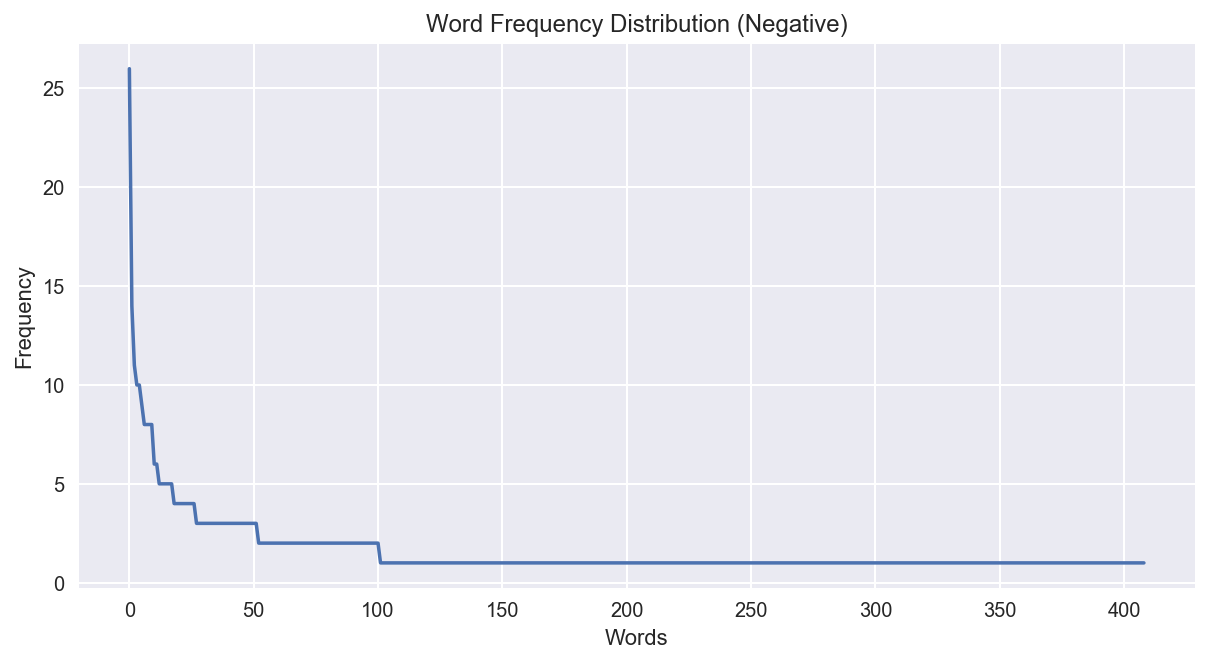

In [193]:
y_val = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

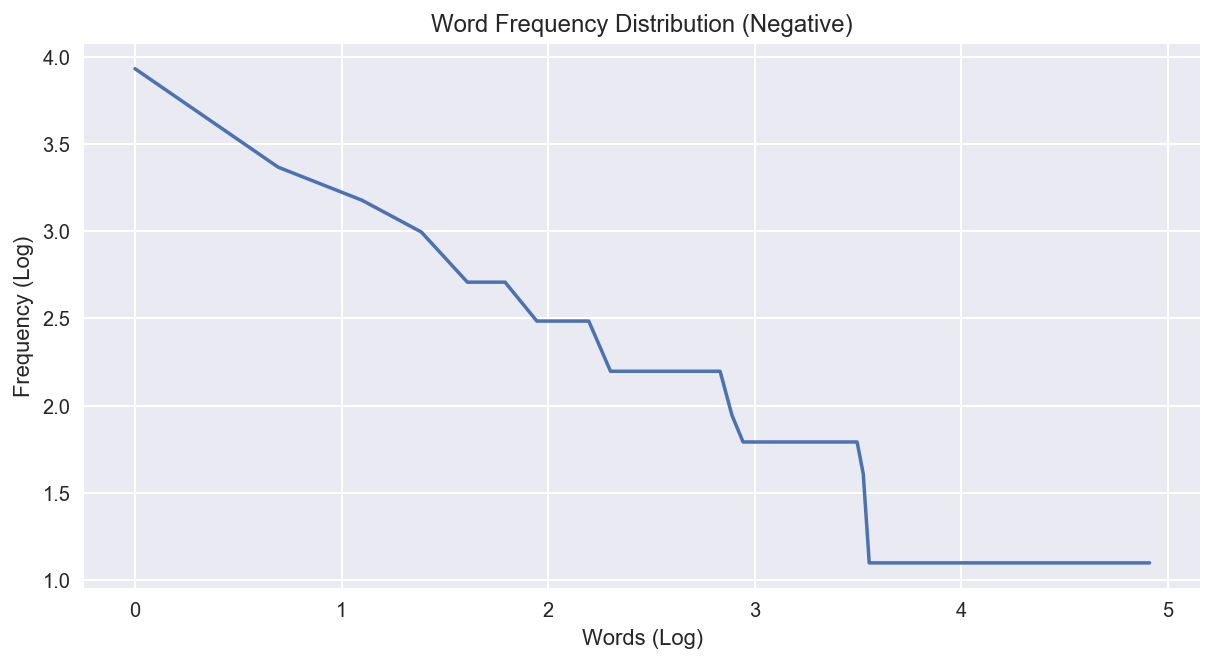

In [194]:

y_final = []
for i, k, z in zip(y_val[0::3], y_val[1::3], y_val[2::3]):
    if i + k + z == 0:
        break
    y_final.append(math.log(i + k + z))

x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Negative)")
plt.plot(x_val, y_final)
plt.show()

In [195]:
def run_sentiment_analysis():
    '''Reads the posts and comments and performs the analysis.'''
    sia = SIA()

In [196]:
## Extension 1.2: Network Node Map for Streaming Media from Reddit web scrape data 

In [197]:
import plotly.offline as py
from plotly.graph_objs import *

import community
import networkx as nx
import colorlover as cl
import numpy as np
import pickle

In [199]:
file = pd.read_csv("reddit1_headlines_labels.csv")
file
#G_reddit=nx.read_edgelist("reddit_headlines_labels.csv", create_using = nx.Graph(), nodetype=str)

,headlines,label
0,Pwwweeease Don't Find Me,0
1,Streaming Deceit w/ Kittyn_Meow,-1
2,Lenovo Legion series,0
3,How do I tell someone I don't want to see them...,1
4,Fortnite S4 Stream - Pay to win 4 sure,1
5,Live right now !,0
6,Getting that Chicken Dinner with Friends!,1
7,External camera for mobile video streaming & c...,0
8,New streamer trying to get a small community s...,0
9,Can I use two DIFFERENT GPU's on one pc to...?,0


In [210]:
csv_file = csv.DictReader(open("reddit1_headlines_labels.csv", "rb"))

In [211]:
    #G = nx.DiGraph()
#for col in df:
 #   for x in list(df.loc[df[col] == 1,'headlines']):
#      G.add_edge(headlines,x)
#G.edges()
#nx.draw(G)